<a href="https://colab.research.google.com/github/NabilaJ22/NNDL-LAB/blob/main/lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.06G/2.06G [01:00<00:00, 36.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = '/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data'

datagen = ImageDataGenerator(rescale=1./255)


train_data = datagen.flow_from_directory(
    data_dir + '/train',  # Directory where your images are located
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Batch size
    class_mode='categorical',  # Labels are one-hot encoded
    shuffle=True
)


X_train, y_train = next(train_data)

Found 5144 images belonging to 3 classes.


Found 5144 images belonging to 3 classes.


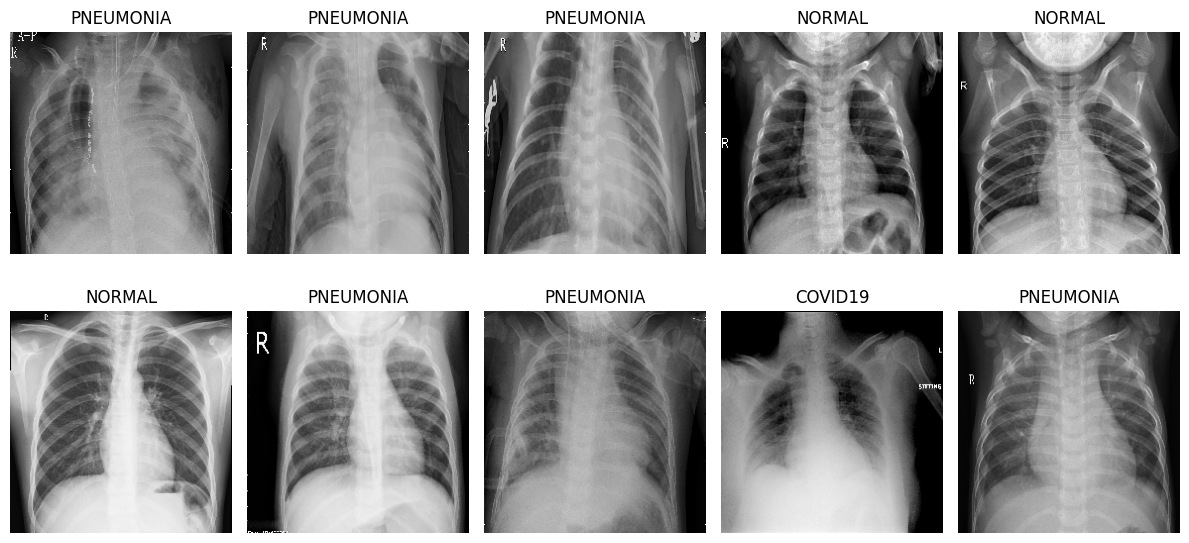

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = '/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data'

# Image data generator with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_data = datagen.flow_from_directory(
    data_dir + '/train',  # Directory where your images are located
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=10,  # Load 10 images at a time
    class_mode='categorical',  # Labels are one-hot encoded
    shuffle=True
)

# Get a batch of 10 images
X_train, y_train = next(train_data)

# Get class labels
class_labels = list(train_data.class_indices.keys())

# Display 10 images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a 2-row, 5-column subplot
    plt.imshow(X_train[i])
    plt.axis('off')  # Hide axes
    label_index = np.argmax(y_train[i])  # Get class index
    plt.title(class_labels[label_index])  # Set title to class label

plt.tight_layout()
plt.show()


Found 5144 images belonging to 3 classes.


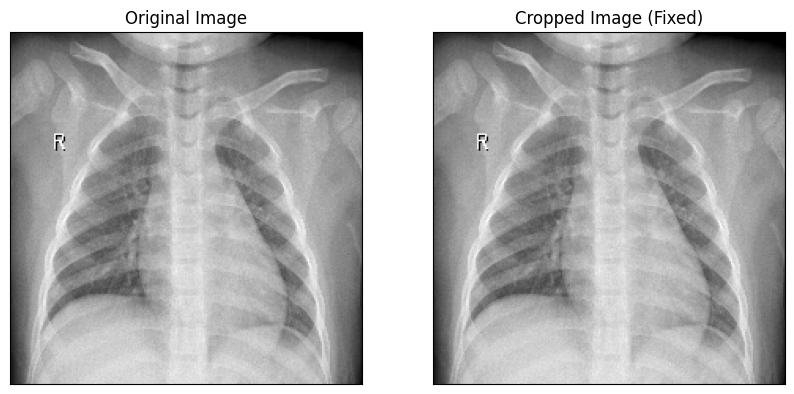

In [ ]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Improved Image Cropping Function
def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]  # Apply threshold
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:  # If no contours found, return original image
        return img

    c = max(cnts, key=cv2.contourArea)  # Get largest contour

    # Get extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 10  # Small padding
    cropped_img = img[max(0, extTop[1]-ADD_PIXELS):extBot[1]+ADD_PIXELS,
                       max(0, extLeft[0]-ADD_PIXELS):extRight[0]+ADD_PIXELS].copy()

    # Ensure output size consistency
    if cropped_img.shape[0] > 0 and cropped_img.shape[1] > 0:
        cropped_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_LINEAR)

    return cropped_img

# Load dataset images
data_dir = '/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data'

datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(224, 224),
    batch_size=1,  # Load 1 image
    class_mode='categorical',
    shuffle=True
)

# Get a sample image
X_train, _ = next(train_data)
sample_img = (X_train[0] * 255).astype(np.uint8)  # Convert back to uint8 format

# Apply cropping
cropped_img = crop_img(sample_img)

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.xticks([]), plt.yticks([])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cropped_img)
plt.xticks([]), plt.yticks([])
plt.title('Cropped Image (Fixed)')

plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the dataset
data_dir = '/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data'

# ImageDataGenerator for rescaling and splitting into training/validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

# Training Data (80% of images)
train_data = datagen.flow_from_directory(
    data_dir + '/train',  # Directory with your images
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Training data (80%)
)

# Validation Data (20% of images)
val_data = datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation data (20%)
)


Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.


In [ ]:
img = cv2.resize(img, (128, 128))  # Resize images to smaller dimensions


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Path to dataset
data_dir = '/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data'

# ImageDataGenerator for normalization and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images to [0, 1]
    rotation_range=40,  # Random rotation
    width_shift_range=0.2,  # Random width shift
    height_shift_range=0.2,  # Random height shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom transformation
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # How to fill missing pixels
    validation_split=0.2  # Split dataset into training (80%) and validation (20%)
)

# Training Data (80% for training)
train_data = datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # For training
)

# Validation Data (20% for validation)
val_data = datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # For validation
)


Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential([
    # Convolutional layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps to 1D
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting

    # Output layer (3 classes)
    Dense(3, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model using the augmented data
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,  # Number of batches per epoch
    epochs=5,  # Number of epochs to train
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size  # Number of validation steps per epoch
)


Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 114s 890ms/step - accuracy: 0.8076 - loss: 0.4857 - val_accuracy: 0.8477 - val_loss: 0.4172
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.7812 - loss: 0.7403 - val_accuracy: 0.8359 - val_loss: 0.4524
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 117s 863ms/step - accuracy: 0.7972 - loss: 0.4717 - val_accuracy: 0.8486 - val_loss: 0.4389
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.7812 - loss: 0.6764 - val_accuracy: 0.8252 - val_loss: 0.4517
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 110s 858ms/step - accuracy: 0.7968 - loss: 0.4619 - val_accuracy: 0.8691 - val_loss: 0.4002


In [ ]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 665ms/step - accuracy: 0.8655 - loss: 0.4010
Validation Loss: 0.4008, Validation Accuracy: 0.8609


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 691ms/step
Classification Report:
              precision    recall  f1-score   support

     COVID19       0.08      0.07      0.07        92
      NORMAL       0.27      0.25      0.26       253
   PNEUMONIA       0.67      0.71      0.69       683

    accuracy                           0.54      1028
   macro avg       0.34      0.34      0.34      1028
weighted avg       0.52      0.54      0.53      1028



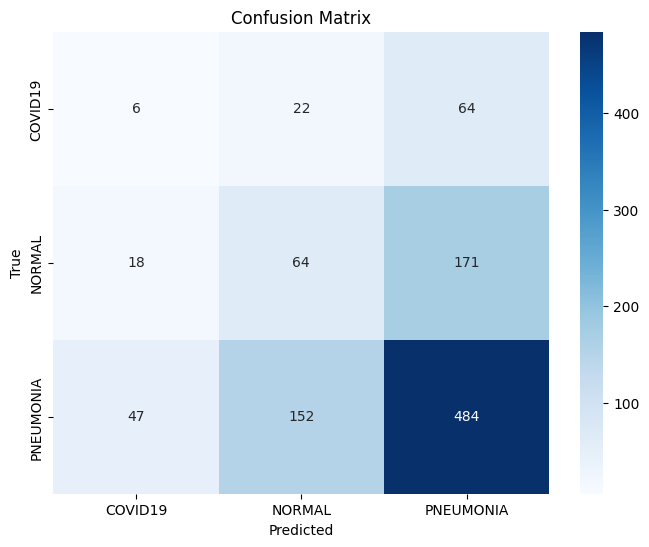

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the entire validation dataset instead of using steps.
# This is done by removing the `steps` argument and using `val_data` directly
y_pred = model.predict(val_data, verbose=1)

# Get the true labels
y_true = val_data.classes  # True labels (validation set)

# Get predicted class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_data.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 118s 915ms/step - accuracy: 0.8328 - loss: 0.4268 - val_accuracy: 0.8589 - val_loss: 0.3871
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 111s 861ms/step - accuracy: 0.8376 - loss: 0.4088 - val_accuracy: 0.8842 - val_loss: 0.3871
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 108s 838ms/step - accuracy: 0.8481 - loss: 0.3953 - val_accuracy: 0.8726 - val_loss: 0.3909
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 108s 836ms/step - accuracy: 0.8503 - loss: 0.3834 - val_accuracy: 0.8881 - val_loss: 0.3575


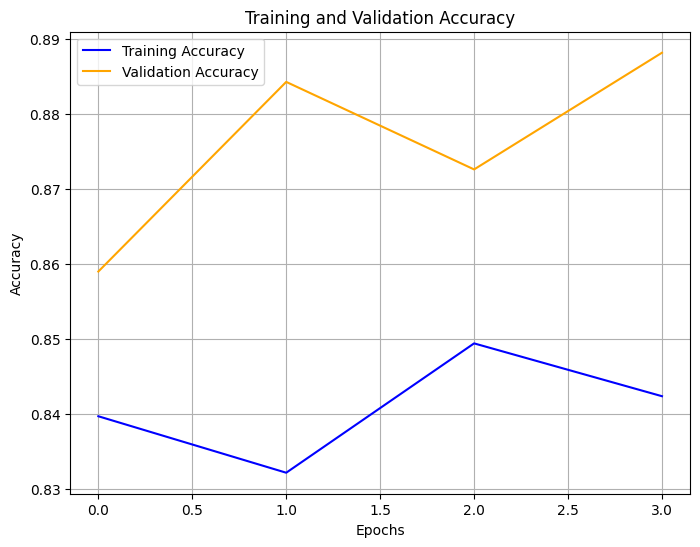

In [ ]:

import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
history = model.fit(train_data, epochs=4, validation_data=val_data)

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


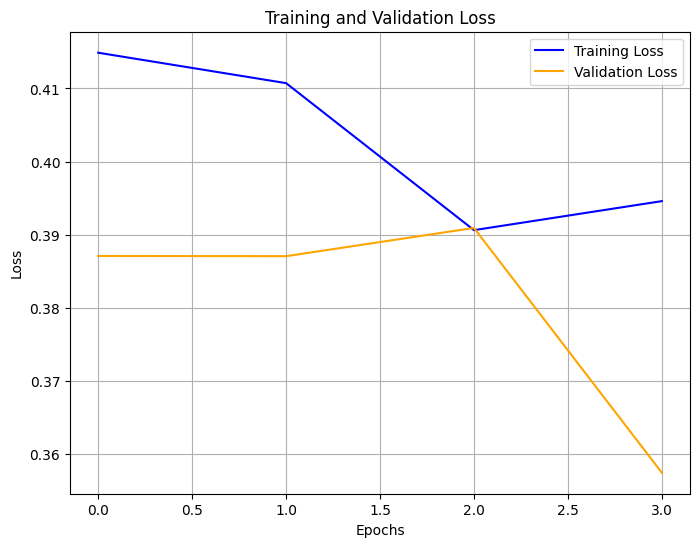

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
